In [53]:
import sys
sys.path.append('..')
import numpy as np
import torch
from streaming.b3_streamer import DualStreamer
from dataloader.datamodule_bravo_multi import ECoGDataModule
import time
import tqdm
import torchaudio
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
import IPython.display as ipd
import torchaudio
import string, re

In [10]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
asr = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [41]:
rnnt_ckpt_path = '../ckpts_generic/hubert-l6_km100_grphemebpe4096-causal_50phrase-recent.ckpt'
vocoder_ckpt_path = '../b3_model_package/lj_hub_u2w_vctk_6-100_embed_short'
unit_analysis = '../b3_model_package/hubert-l6_km100_analysis.npy'

In [48]:
dual_streamer = DualStreamer(
                 rnnt_ckpt_path, vocoder_ckpt_path, 
                 buffer_size=20, 
                 unit_beam_width=5,
                 unit_best_n=5, 
                 unit_step_max_tokens=20, 
                 unit_temperature=1.0,
                 text_beam_width=5,
                 text_best_n=5, 
                 text_step_max_tokens=20, 
                 text_temperature=1.0,
                 # about vocab & output config
                 left_context=0,
                 input_sr=200,
                 audio_sr=16000, 
                 enc_q=4, 
                 vocab_size=100, # for km100
                 sil_id=56, # for km100
                 unit_analysis=unit_analysis, 
                 collapsed=True,
                 vowel_weight=2.5, 
                 force_max_unit=False,  
                 use_wav_buffer=False, 
                 output_audio_len=None,
                 # about loading model
                 device='cuda')
    
                        

Loaded model parameters from ../b3_model_package/lj_hub_u2w_vctk_6-100_embed_short/best_mel_ckpt.pkl.


In [43]:
data_config = {'root_dir': '/home/cheoljun/bravo_packaged_data',
              'hb_dir': '/data/cheoljun/b3_audio_bark_wbw/unit_label/hubert-l6_km100/',
              'textidx_file': '/data/cheoljun/b3_audio_scale-2/50_phrase/recent_file2textindex.npy',
              'paradigm': '50_phrase_recent',
              'batch_size': 50,
              'num_workers': 8,
              'include_ecog': True,
              'include_unit': True,
              'include_phoneme': True,
              'load_list': ['ecog'],
              'text_list': ['unit', 'phoneme']}

In [49]:
datamodule = ECoGDataModule(**data_config)
test_loader = datamodule.test_dataloader()
test_loader.dataset.transform=None

In [54]:
# output text is cumulative decoding of text.
# output wav has the same length (in seconds) with the input buffer size.
#  -- This is done by having an internal buffer in streamer, 
#  -- which means we may need to keep feeding some empty inputs to output all the audios in the buffer

times = []
buffer_size = 20
unit_wer_results = []
unit_cer_results = []
text_wer_results = []
text_cer_results = []
regex = re.compile('[%s]' % re.escape(string.punctuation))

for di in tqdm.tqdm(range(len(test_loader.dataset))):
    x = test_loader.dataset.__getitem__(di)
    input_all = x['ecog']
    wavs=[]
    dual_streamer.clear_cache()
    for i in range(0,int(len(input_all)//buffer_size*buffer_size),buffer_size):
        start_time = time.time()
        x = input_all[i:i+buffer_size]
        wav,text = dual_streamer(x)
        #print(f'PRED[{int(1/200*i*1000):03d}ms]-', text)
        wavs.append(wav)
        end_time = time.time()
        times.append(end_time-start_time)
    wavs.append(dual_streamer.unit_streamer.wav_buffer)
    wavs = np.concatenate(wavs)
    input_features = processor(wavs, sampling_rate=16000, return_tensors="pt").input_features 
    with torch.no_grad():
        predicted_ids = asr.generate(input_features)
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    
    
    ## Get error rate
    gt_text = datamodule.idx2text['_'.join(datamodule.test_files[di].split('_')[1:3])]
    gt_text = regex.sub('', gt_text.lower())
    gt_text = ' '.join([t for t in gt_text.split(' ') if t != ''])
    unit_pred_text = transcription
    text_pred_text = text
    
    unit_cer_results.append(torchaudio.functional.edit_distance(gt_text.lower(), unit_pred_text.lower()) / len(gt_text))
    text_cer_results.append(torchaudio.functional.edit_distance(gt_text.lower(), text_pred_text.lower()) / len(gt_text))
    unit_wer_results.append(torchaudio.functional.edit_distance(unit_pred_text.lower().split(' '), gt_text.lower().split(' ')) / len(gt_text.split(' ')))
    text_wer_results.append(torchaudio.functional.edit_distance(text_pred_text.lower().split(' '), gt_text.lower().split(' ')) / len(gt_text.split(' ')))

100%|█████████████████████████████████████████| 100/100 [18:17<00:00, 10.97s/it]


In [38]:
ipd.display(ipd.Audio(wavs, rate=16000))

In [55]:
np.mean(text_wer_results)

0.1809166666666667

In [57]:
np.mean(unit_wer_results)

0.6593730158730159

Text(0, 0.5, 'CER')

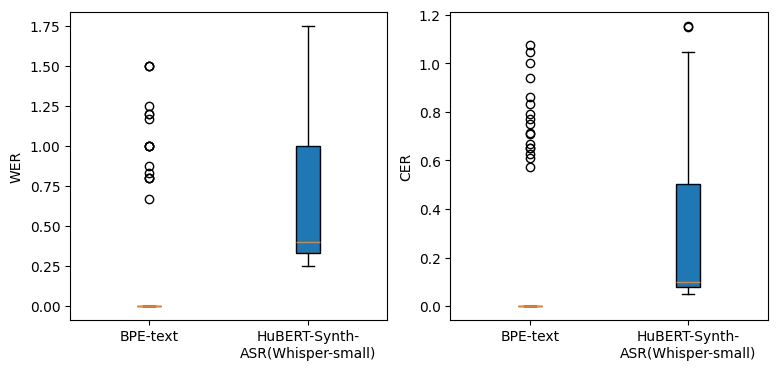

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(19680801)
all_data = [text_wer_results,unit_wer_results]
all_data2 = [text_cer_results,unit_cer_results]
labels = ['BPE-text', 'HuBERT-Synth-\nASR(Whisper-small)']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_ylabel('WER')
bplot2 = ax2.boxplot(all_data2,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks

ax2.set_ylabel('CER')

In [72]:
np.mean(unit_wer_results)

0.6593730158730159

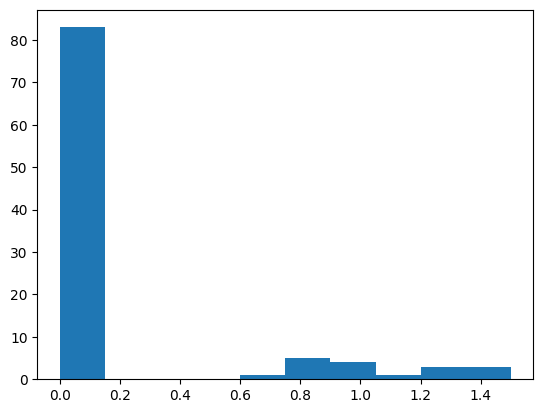

In [69]:
plt.hist(text_wer_results)
plt.show()